### Introduction

Link prediction demo for cora dataset (homegeneous network) where all nodes are papers and edges between nodes are citation links, e.g., paper A cites paper B. 

Each paper has a **subject** attribute with one of 7 values denoting the subject area of the paper.

This demo notebook **demonstrates how to predict citation links between papers** using the random walk-based representation learning method Node2Vec.

In [1]:
import os
import numpy as np
import networkx as nx
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
# stellar ml library imports
from stellar.data.epgm import EPGM
from stellar.data.edge_splitter import EdgeSplitter
# Node2Vec representation learning
from utils.node2vec_feature_learning import Node2VecFeatureLearning

In [2]:
# Default parameters for Node2Vec
parameters = {
    "p": 1.,  # Parameter p
    "q": 1.,  # Parameter q
    "dimensions": 128,  # dimensionality of node2vec embeddings
    "num_walks": 10,  # Number of walks from each node
    "walk_length": 80,  # Walk length
    "window_size": 10,  # Context size for word2vec
    "iter": 1,  # number of SGD iterations (epochs)
    "workers": multiprocessing.cpu_count(),  # number of workers for word2vec
    "weighted": False,  # is graph weighted?
    "directed": False,  # are edges directed?
}

In [3]:
def read_graph(graph_file, dataset_name):
    """
    Reads the input network in networkx.

    Args:
        graph_file: The directory where graph in EPGM format is stored.
        dataset_name: The name of the graph selected out of all the graph heads in EPGM file.

    Returns:
        The graph in networkx format
    """
    try:  # assume args.input points to an EPGM graph
        G_epgm = EPGM(graph_file)
        graphs = G_epgm.G["graphs"]
        if (
            dataset_name is None
        ):  # if dataset_name is not given, use the name of the 1st graph head
            dataset_name = graphs[0]["meta"]["label"]
            print(
                "WARNING: dataset name not specified, using dataset '{}' in the 1st graph head".format(
                    dataset_name
                )
            )
        graph_id = None
        for g in graphs:
            if g["meta"]["label"] == dataset_name:
                graph_id = g["id"]

        g = G_epgm.to_nx(graph_id, parameters["directed"])
        if parameters["weighted"]:
            raise NotImplementedError
        else:
            # This is the correct way to set the edge weight in a MultiGraph.
            edge_weights = {e: 1 for e in g.edges(keys=True)}
            nx.set_edge_attributes(g, name="weight", values=edge_weights)
    except:  # otherwise, assume arg.input points to an edgelist file
        if parameters["weighted"]:
            g = nx.read_edgelist(
                graph_file,
                nodetype=int,
                data=(("weight", float),),
                create_using=nx.DiGraph(),
            )
        else:
            g = nx.read_edgelist(graph_file, nodetype=int, create_using=nx.DiGraph())
            for edge in g.edges():
                g[edge[0]][edge[1]]["weight"] = 1  # {'weight': 1}

        if not parameters["directed"]:
            g = g.to_undirected()

    if not nx.is_connected(g):
        g = max(nx.connected_component_subgraphs(g, copy=True), key=len)

    print(
        "Graph statistics: {} nodes, {} edges".format(
            g.number_of_nodes(), g.number_of_edges()
        )
    )
    return g

def get_subgraph_bfs(g, n, d):
    nodes = []  # the nodes in the subgraph
    frontier = [n]

    for _ in range(d+1):
        next_frontier = []
        while len(frontier) > 0:
            cn = frontier.pop()
            nodes.extend([cn])
            nn = list(nx.neighbors(g, cn))
            next_frontier.extend(nn)
        frontier.extend(next_frontier)

    nodes = list(set(nodes))

    return nodes

def link_prediction_clf(feature_learner, edge_data, binary_operators=None):
    """
    Performs link prediction given that node features have already been computed. It uses the node features to
    derive edge features using the operators given. Then it trains a Logistic Regression classifier to predict
    links between nodes.

    Args:
        feature_learner: Representation learning object.
        edge_data: (2-tuple) Positive and negative edge data for training the classifier
        binary_operators: Binary operators applied on node features to produce the corresponding edge feature.

    Returns:
        Returns the ROCAUC score achieved by the classifier for each of the specified binary operators.
    """
    scores = []  # the auc values for each binary operator (based on test set performance)
    clf_best = None
    score_best = 0
    op_best = ""

    if binary_operators is None:
        print("WARNING: Using default binary operator 'h'")
        binary_operators = ["h"]

    # for each type of binary operator
    for binary_operator in binary_operators:
        X, y = feature_learner.transform(edge_data, binary_operator)
        #
        # Split the data and keep X_test, y_test for scoring the model; setting the random_state to
        # the same constant for every iteration gives the same split of data so the comparison is fair.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.75, test_size=0.25
        )
        # LogisticRegressionCV automatically tunes the parameter C using cross validation and the ROC AUC metric
        clf = Pipeline(
            steps=[
                ("sc", StandardScaler()),
                (
                    "clf",
                    LogisticRegressionCV(
                        Cs=10, cv=10, scoring="roc_auc", verbose=False
                    ),
                ),
            ]
        )
        clf.fit(X_train, y_train)

        y_pred = clf.predict_proba(X_test)  # predict on the test set
        if clf.classes_[0] == 1:  # only needs probabilities of positive class
            score_auc = roc_auc_score(y_test, y_pred[:, 0])
        else:
            score_auc = roc_auc_score(y_test, y_pred[:, 1])

        if score_auc >= score_best:
            score_best = score_auc
            clf_best = clf
            op_best = binary_operator

        print(
            "Operator: {} Score (on test set of edge_data): {}".format(
                binary_operator, score_auc
            )
        )
        scores.append({"op": binary_operator, "score": score_auc})

    return scores, clf_best, op_best


def predict_links(feature_learner, edge_data, clf, binary_operators=None):
    """
    Given a node feature learner and a trained classifier, it computes edge features, uses the classifier to predict
    the given edge data and calculate prediction accuracy.
    :param feature_learner:
    :param edge_data:
    :param clf:
    :param binary_operators:
    :return:
    """
    if binary_operators is None:
        print("WARNING: Using default binary operator 'h'")
        binary_operators = ["h"]

    scores = []  # the auc values for each binary operator (based on test set performance)

    # for each type of binary operator
    for binary_operator in binary_operators:
        # Derive edge features from node features using the given binary operator
        X, y = feature_learner.transform(edge_data, binary_operator)
        #
        y_pred = clf.predict_proba(X)  # predict
        if clf.classes_[0] == 1:  # only needs probabilities of positive class
            score_auc = roc_auc_score(y, y_pred[:, 0])
        else:
            score_auc = roc_auc_score(y, y_pred[:, 1])

        print("Prediction score:", score_auc)
        scores.append({"op": binary_operator, "score": score_auc})

    return scores

def predict(feature_learner, edge_data, clf, binary_operators=None):
    """
    Given a node feature learner and a trained classifier, it computes edge features, uses the classifier to predict
    the given edge data and calculate prediction accuracy.
    :param feature_learner:
    :param edge_data:
    :param clf:
    :param binary_operators:
    :return: a prediction probability for each binary operator in a dictionary where operator is key and prediction is
    the value.
    """

    if binary_operators is None:
        print("WARNING: Using default binary operator 'h'")
        binary_operators = ["h"]

    predictions = {}
    # for each type of binary operator
    for binary_operator in binary_operators:
        # Derive edge features from node features using the given binary operator
        X, y = feature_learner.transform(edge_data, binary_operator)
        #
        y_pred = clf.predict_proba(X)  # predict

        predictions[binary_operator] = y_pred

    return predictions

def train_homogeneous_graph(
    g_train,
    g_test,
    output_node_features,  # filename for writing node embeddings
    edge_data_ids_train,
    edge_data_labels_train,  # train edge data
    edge_data_ids_test,
    edge_data_labels_test,  # test edge data
):
    # Using g_train and edge_data_train train a classifier for edge prediction
    feature_learner_train = Node2VecFeatureLearning(
        g_train, embeddings_filename=os.path.expanduser(output_node_features)
    )
    feature_learner_train.fit(
        p=parameters["p"],
        q=parameters["q"],
        d=parameters["dimensions"],
        r=parameters["num_walks"],
        l=parameters["walk_length"],
        k=parameters["window_size"],
    )
    # Train the classifier
    binary_operators = ["h"]  #, "avg", "l1", "l2"]
    scores_train, clf_edge, binary_operator = link_prediction_clf(
        feature_learner=feature_learner_train,
        edge_data=(edge_data_ids_train, edge_data_labels_train),
        binary_operators=binary_operators,
    )

    # Do representation learning on g_test and use the previously trained classifier on g_train to predict
    # edge_data_test
    feature_learner_test = Node2VecFeatureLearning(
        g_test, embeddings_filename=os.path.expanduser(output_node_features)
    )
    feature_learner_test.fit(
        p=parameters["p"],
        q=parameters["q"],
        d=parameters["dimensions"],
        r=parameters["num_walks"],
        l=parameters["walk_length"],
        k=parameters["window_size"],
    )

    scores = predict_links(
        feature_learner=feature_learner_test,
        edge_data=(edge_data_ids_test, edge_data_labels_test),
        clf=clf_edge,
        binary_operators=[binary_operator],
    )

    print("\n  **** Scores on test set ****\n")
    for score in scores:
        print("     Operator: {}  Score: {:.2f}".format(score["op"], score["score"]))
    print("\n  ****************************")
    
    return feature_learner_train, feature_learner_test,clf_edge

### Load the dataset

In [4]:
cora_epgm_location = os.path.expanduser("~/Projects/data/cora/cora.epgm/")
dataset_name = 'cora'
g_nx = read_graph(graph_file=cora_epgm_location, dataset_name=dataset_name)

...reading /Users/eli024/Projects/data/cora/cora.epgm/graphs.json using utf-8 encoding...
...reading /Users/eli024/Projects/data/cora/cora.epgm/vertices.json using utf-8 encoding...
...reading /Users/eli024/Projects/data/cora/cora.epgm/edges.json using utf-8 encoding...
Converting the EPGM graph 9ccd0dd106204767a723747a8b8d5b8a to NetworkX graph...
Graph statistics: 2485 nodes, 5069 edges


### Construct train and test splits of the input data

In [5]:
# Test graph and edge test data
edge_splitter_test = EdgeSplitter(g_nx)
g_test, edge_data_ids_test, edge_data_labels_test = edge_splitter_test.train_test_split( 
    p=0.1, method='global'
)

# Train graph and edge train data
edge_splitter_train = EdgeSplitter(g_test, g_nx)
g_train, edge_data_ids_train, edge_data_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method='global'
)

** Sampled 258 positive and 258 negative edges. **
** Sampled 232 positive and 232 negative edges. **


In [6]:
# Train and Test graphs should be of type nx.Graph
g_test = nx.Graph(g_test)
g_train = nx.Graph(g_train)

### Train the link prediction model and evaluate on test data

In [7]:
train_fl, test_fl, clf_edge = train_homogeneous_graph(
    g_train=g_train,
    g_test=g_test,
    output_node_features='embeddings.emb',
    edge_data_ids_train=edge_data_ids_train,
    edge_data_labels_train=edge_data_labels_train,
    edge_data_ids_test=edge_data_ids_test,
    edge_data_labels_test=edge_data_labels_test,
)

(Node2VecFeatureLearning) Time for random walks 10 seconds
(Node2VecFeatureLearning) Time for learning embeddings 8 seconds.
Total time for fit() 19.168335676193237 seconds
Operator: h Score (on test set of edge_data): 0.9259589652096343
(Node2VecFeatureLearning) Time for random walks 10 seconds
(Node2VecFeatureLearning) Time for learning embeddings 9 seconds.
Total time for fit() 19.204694986343384 seconds
Prediction score: 0.885073012439

  **** Scores on test set ****

     Operator: h  Score: 0.89

  ****************************


### Visualise representations of edge data

Learned edge embeddings have 128 dimensions but for visualisation we project them down to 2 dimensions. Green points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

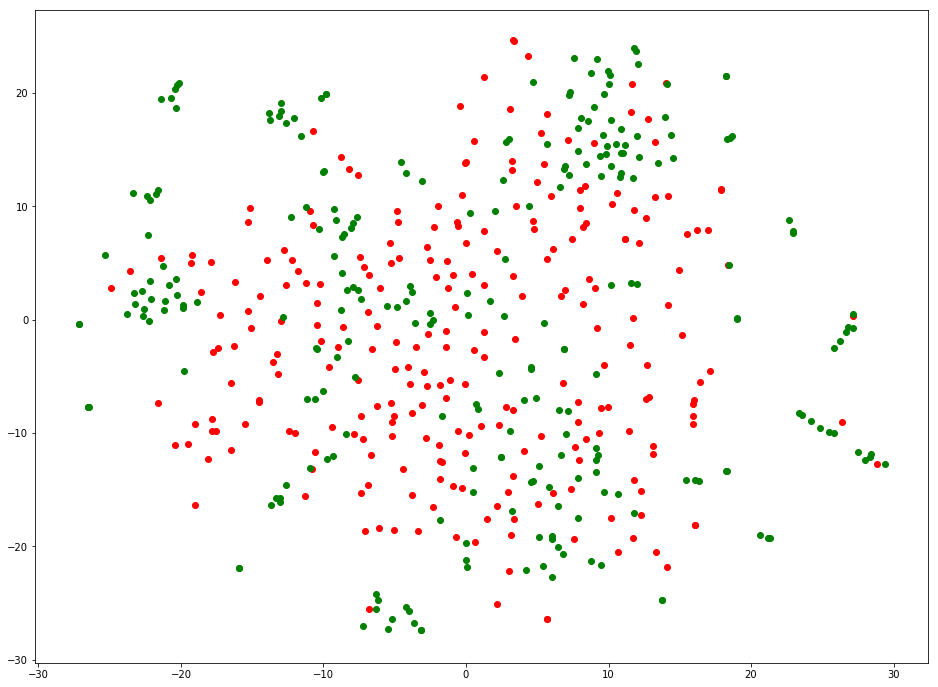

In [9]:
# Calculate edge features for test data
edge_data = (edge_data_ids_test, edge_data_labels_test)
X, y = test_fl.transform(edge_data, 'h')

# Learn a projection from 128 dimensions to 2
tsne = TSNE(n_components=2, init='random', random_state=0)
X_transformed = tsne.fit_transform(X)

# plot the 2-dimensional points
red = y == 0
green = y == 1
plt.figure(figsize=(16,12))
plt.scatter(X_transformed[red, 0], X_transformed[red, 1], c="r")
plt.scatter(X_transformed[green, 0], X_transformed[green, 1], c="g")

In [34]:
# collect the nodes in edge_data_ids
nodes = { u for u in edge_data_ids_test.flatten()}
# create subgraph using only the above nodes
g_test_subgraph = g_test.subgraph(nodes)
print("Nubmer of nodes in subgraph {} vs {} in full graph".format(g_test_subgraph.number_of_nodes(), g_test.number_of_nodes()))
print("Nubmer of edges in subgraph {} vs {} in full graph".format(g_test_subgraph.number_of_edges(), g_test.number_of_edges()))

Nubmer of nodes in subgraph 829 vs 2485 in full graph
Nubmer of edges in subgraph 885 vs 4811 in full graph


(-1.068929743075546,
 0.92887182166593907,
 -1.019748867644882,
 1.098717809810257)

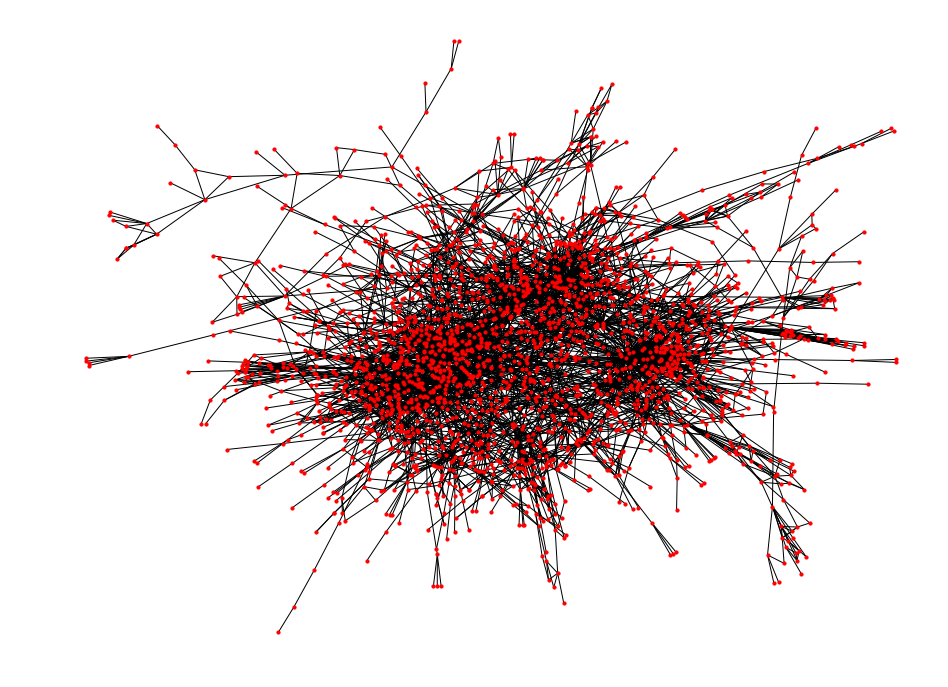

In [10]:
# draw the full graph
plt.figure(figsize=(16,12))
nx.draw_networkx(g_test, pos=nx.spring_layout(g_test), with_labels=False, node_size=10)
plt.axis('off')

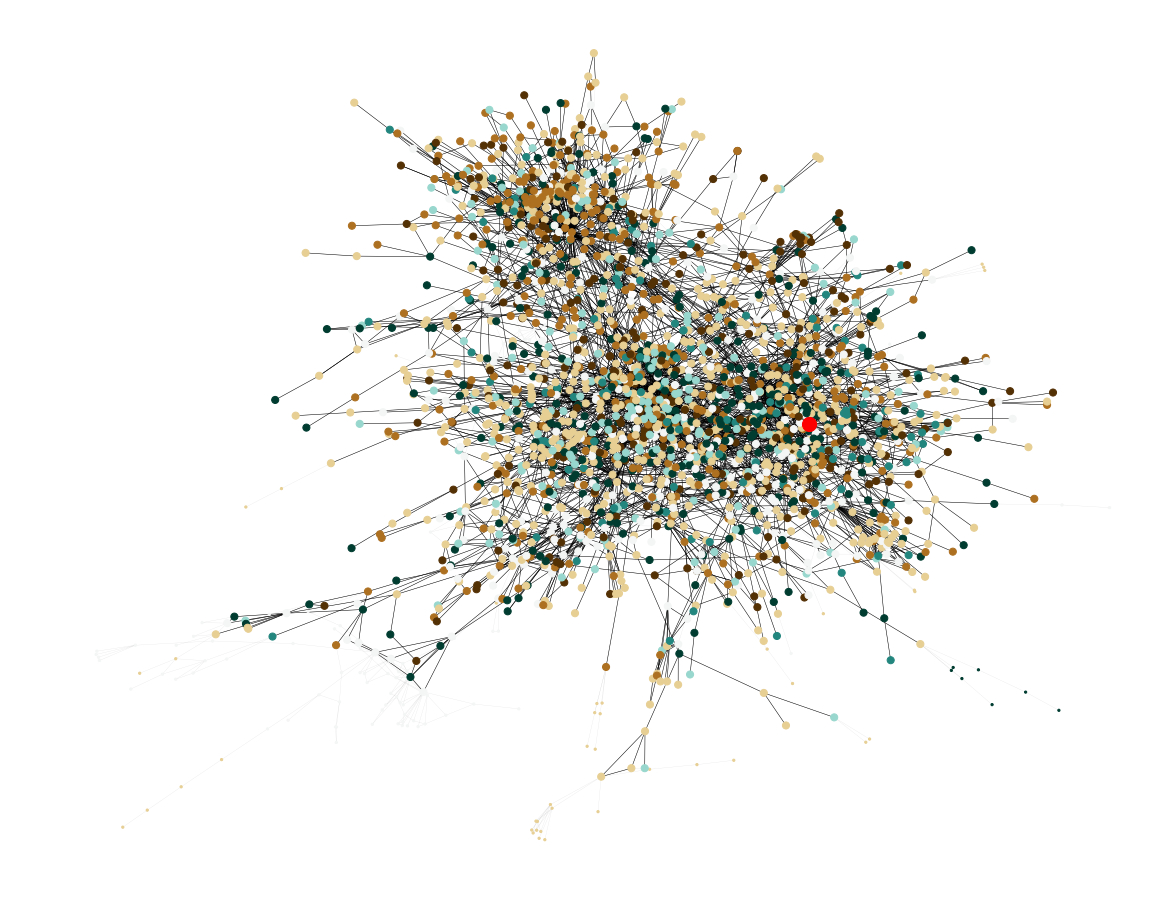

In [95]:
np.random.seed(seed=42)

node_labels = [ n[1]['subject'] for n in g_nx.nodes(data=True) ]
ulabels = np.unique(node_labels)
label_map = { l: i for i, l in enumerate(ulabels)}
node_colours = [ label_map[nl]/7. for nl in node_labels]

# layout
pos = nx.spring_layout(g_nx)

# draw the test graph
plt.figure(figsize=(20,16))
nx.draw_networkx(g_nx, pos=pos, with_labels=False, node_size=5, edgelist=[],
                node_color=node_colours, cmap=plt.cm.BrBG)

# draw the edges in the full graph
nx.draw_networkx(g_nx, with_labels=False, pos=pos, nodelist=[], 
                 edgelist=list(g_nx.edges()), alpha=0.1, width=0.3 )


# collect the nodes in the positive and negative edge samples
nodes = list({u for u in edge_data_ids_test.flatten() })

# create subgraph from the first node in nodes
sg = get_subgraph_bfs(g=g_nx, n=nodes[0], d=8)
node_labels = [ g_nx.node[n]['subject'] for n in sg ]
node_colours = [ label_map[nl]/7. for nl in node_labels]

nx.draw(nx.subgraph(g_test, sg), pos=pos, node_size=50, 
        with_labels=False, width=0.5, node_color=node_colours, cmap=plt.cm.BrBG)
nx.draw_networkx_nodes(nx.subgraph(g_test, sg), pos, nodelist=[nodes[0]], node_size=200, 
                       node_color='r')
plt.axis('off')
plt.show()

['35' '44368'] 1


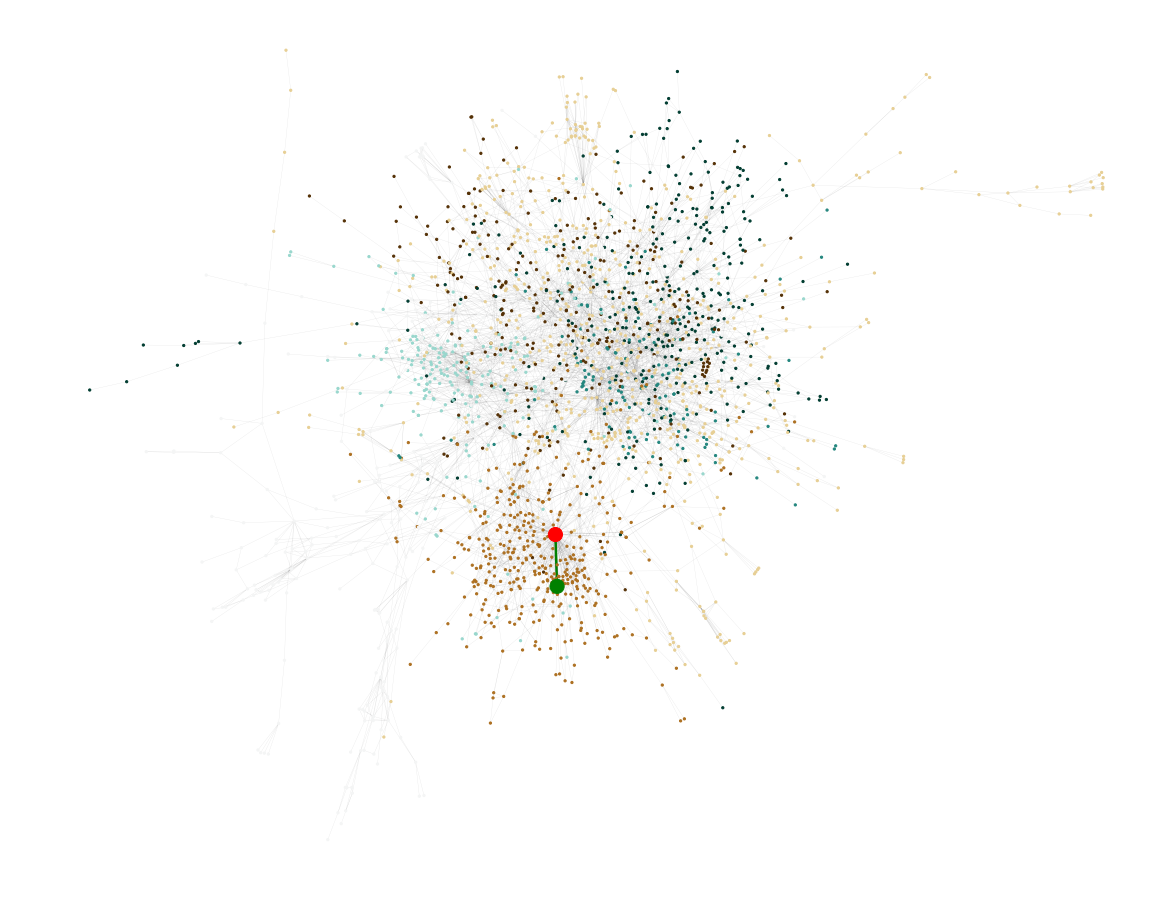

In [30]:
np.random.seed(seed=42)

node_labels = [ n[1]['subject'] for n in g_nx.nodes(data=True) ]
ulabels = np.unique(node_labels)
label_map = { l: i for i, l in enumerate(ulabels)}
node_colours = [ label_map[nl]/7. for nl in node_labels]

# layout
pos = nx.spring_layout(g_nx)

# draw the test graph
plt.figure(figsize=(20,16))
nx.draw_networkx(g_nx, pos=pos, with_labels=False, node_size=5, edgelist=[],
                node_color=node_colours, cmap=plt.cm.BrBG)

# draw the edges in the full graph
nx.draw_networkx(g_nx, with_labels=False, pos=pos, nodelist=[], 
                 edgelist=list(g_nx.edges()), alpha=0.1, width=0.3 )


# collect the nodes in the positive and negative edge samples
nodes = list({u for u in edge_data_ids_test.flatten() })

edge_index = 1

nx.draw(g_nx, pos=pos, node_size=200, 
        nodelist=[edge_data_ids_test[edge_index][0], edge_data_ids_test[edge_index][1]], 
        edgelist=[], with_labels=False, width=0.5, node_color=['r', 'g'])

path = nx.shortest_path(g_nx, source=edge_data_ids_test[edge_index][0],
                        target=edge_data_ids_test[edge_index][1])
path_edges = list(zip(path,path[1:]))
nx.draw_networkx_edges(g_nx, pos, edgelist=path_edges, edge_color='m',width=1.5)

# Use the trained classifier to make a prediction
print(edge_data_ids_test[edge_index], edge_data_labels_test[edge_index])
y_pred = predict(feature_learner=test_fl, 
                 edge_data=([edge_data_ids_test[edge_index]], 
                            [edge_data_labels_test[edge_index]]), 
                            clf=clf_edge, binary_operators=['h'])

if edge_data_labels_test[edge_index] == 0:  # negative edge so draw a dashed edge
    link_style = 'dashed'
    if y_pred['h'][0][0] > 0.5:  # correctly predicted no edge
        # draw green dashed line between the source and target nodes
        link_color = 'g'
    else:  # incorrectly predicted an edge
        # draw a red dashed line between the source and target nodes
        link_color = 'r'
else:  # positive edge so draw a solid edge
    link_style = 'solid'
    if y_pred['h'][0][1] > 0.5:  # correctly predicted and edge
        # draw green solid line between the source and target nodes
        link_color = 'g'
    else:  # incorrectly predicted no edge
        # draw a red solid line between the source and target nodes
        link_color = 'r'

nx.draw_networkx_edges(g_nx, pos=pos, 
                       edgelist=[(edge_data_ids_test[edge_index][0], edge_data_ids_test[edge_index][1]),], 
                       with_labels=False, width=2.5, edge_color=link_color, style=link_style)

    

In [24]:
edge_data_ids_test[edge_index]

array(['1125992', '592973'], dtype=object)

In [25]:
edge_index = -1
print(edge_data_ids_test[edge_index], edge_data_labels_test[edge_index])
y_pred = predict(feature_learner=test_fl, 
        edge_data=([edge_data_ids_test[edge_index]], [edge_data_labels_test[edge_index]]), 
        clf=clf_edge, binary_operators=['h'])

['1125992' '592973'] 0


In [14]:
pr = predict(feature_learner=test_fl, 
             edge_data=(edge_data_ids_test, edge_data_labels_test), 
             clf=clf_edge, binary_operators=['h'])

In [26]:
y_pred['h'][0][0]

0.97607947300142173